In [11]:
!pip install torchvision

import torch.optim as optim
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import FashionMNIST
import matplotlib.pyplot as plt

# 데이터셋을 로드하고 전처리하기

# torchvision.transforms.Compose를 사용하여 여러 개의 변환을 연달아 적용하는 변환 파이프라인을 생성합니다.
transform = transforms.Compose([
    transforms.ToTensor(),  # PIL 이미지나 numpy 배열을 PyTorch 텐서로 변환합니다.
    transforms.Normalize((0.5,), (0.5,))  # 입력 텐서를 평균과 표준편차를 이용해 정규화합니다.
])

# torchvision.datasets.FashionMNIST를 사용하여 FashionMNIST 데이터셋을 로드합니다.
# root는 데이터셋이 저장될 경로를 지정하며, train=True로 설정하면 학습 데이터셋을 로드합니다.
# download=True로 설정하면 데이터셋이 없는 경우 인터넷에서 다운로드합니다.
# transform에는 위에서 정의한 변환 파이프라인을 적용합니다.
trainset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)

# torch.utils.data.DataLoader를 사용하여 데이터셋을 배치 단위로 로드하는 데이터 로더를 생성합니다.
# batch_size는 한 번에 로드할 데이터 샘플의 개수를 지정합니다.
# shuffle=True로 설정하면 데이터를 섞어서 로드하며, 학습 시 데이터의 순서를 무작위로 만듭니다.
trainloader = DataLoader(trainset, batch_size=128, shuffle=True)


In [12]:
import torch.nn as nn
%pip install torchsummary  # torchsummary 설치
from torchsummary import summary  # torchsummary에서 summary 함수를 임포트

# FashionNet 클래스 정의: Fashion MNIST 데이터셋에 대한 신경망 모델
class FashionNet(nn.Module):
    def __init__(self):
        super(FashionNet, self).__init__()
        # Convolutional layer: 입력 채널 1개, 출력 채널 16개, 커널 크기 3x3, 스트라이드 1, 패딩 1
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1)
        # Max pooling layer: 커널 크기 2x2, 스트라이드 2, 패딩 0
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        # Fully connected layer 1: 입력 크기 16 * 14 * 14, 출력 크기 128
        self.fc1 = nn.Linear(16 * 14 * 14, 128)
        # Fully connected layer 2: 입력 크기 128, 출력 크기 10 (클래스 개수)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        # Forward pass 구현: Convolutional layer -> Max pooling layer -> Fully connected layers
        x = self.pool(nn.functional.relu(self.conv1(x)))  # ReLU 활성화 함수와 pooling을 연속적으로 적용
        x = x.view(-1, 16 * 14 * 14)  # Flatten the input for the fully connected layers
        x = nn.functional.relu(self.fc1(x))  # 첫 번째 fully connected layer에 ReLU를 적용
        x = nn.functional.log_softmax(self.fc2(x), dim=1)  # 두 번째 fully connected layer에 log softmax를 적용하여 확률 계산
        return x

# FashionNet 모델의 인스턴스 생성
fashion_net = FashionNet()

# 모델 구조 요약 정보 출력
summary(fashion_net, input_size=(1, 28, 28))  # 입력 이미지의 크기는 (1, 28, 28)이며, 채널은 흑백 이미지이므로 1


Note: you may need to restart the kernel to use updated packages.
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 28, 28]             160
         MaxPool2d-2           [-1, 16, 14, 14]               0
            Linear-3                  [-1, 128]         401,536
            Linear-4                   [-1, 10]           1,290
Total params: 402,986
Trainable params: 402,986
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.12
Params size (MB): 1.54
Estimated Total Size (MB): 1.66
----------------------------------------------------------------


In [13]:
import torch
from torch import optim
import torch.nn.functional as F

def train(model, train_loader, test_loader, epochs=5):
    # GPU 사용 가능 여부에 따라 장치 선택
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)  # 모델을 선택한 장치로 이동
    optimizer = optim.Adam(model.parameters(), lr=0.001)  # Adam 옵티마이저 설정
    criterion = torch.nn.CrossEntropyLoss()  # CrossEntropyLoss를 손실 함수로 사용

    # 학습 과정에서 기록할 히스토리 딕셔너리
    history = {'train_loss': [], 'train_acc': [], 'test_loss': [], 'test_acc': []}

    try:
        for epoch in range(epochs):
            model.train()  # 모델을 학습 모드로 설정
            train_loss, train_correct, train_total = 0, 0, 0
            for data, target in train_loader:
                data, target = data.to(device), target.to(device)  # 데이터와 타겟을 선택한 장치로 이동
                optimizer.zero_grad()  # 그래디언트 초기화
                output = model(data)  # 모델에 입력 데이터를 전달하여 출력 계산
                loss = criterion(output, target)  # 손실 계산
                loss.backward()  # 역전파 수행
                optimizer.step()  # 옵티마이저로 모델 파라미터 업데이트

                # 정확도 및 손실 기록
                train_loss += loss.item()
                _, predicted = torch.max(output.data, 1)
                train_total += target.size(0)
                train_correct += (predicted == target).sum().item()

            # 한 에폭이 끝난 후 평균 손실과 정확도 계산
            train_loss /= len(train_loader.dataset)
            train_acc = 100. * train_correct / train_total
            history['train_loss'].append(train_loss)
            history['train_acc'].append(train_acc)

            # 테스트 과정에서 모델을 평가 (그래디언트 계산이 필요 없으므로 torch.no_grad() 내부에서 진행)
            model.eval()  # 모델을 평가 모드로 설정
            test_loss, test_correct, test_total = 0, 0, 0
            with torch.no_grad():
                for data, target in test_loader:
                    data, target = data.to(device), target.to(device)  # 데이터와 타겟을 선택한 장치로 이동
                    output = model(data)  # 모델에 입력 데이터를 전달하여 출력 계산
                    test_loss += criterion(output, target).item()  # 테스트 손실 계산
                    _, predicted = torch.max(output.data, 1)
                    test_total += target.size(0)
                    test_correct += (predicted == target).sum().item()

            # 평균 테스트 손실과 정확도 계산 및 기록
            test_loss /= len(test_loader.dataset)
            test_acc = 100. * test_correct / test_total
            history['test_loss'].append(test_loss)
            history['test_acc'].append(test_acc)

            # 에폭마다 결과 출력
            print(f'Epoch {epoch+1}/{epochs}: Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%')

    except Exception as e:
        print(f"An error occurred: {e}")
        return None

    return history  # 학습 과정에서의 손실과 정확도 기록을 담은 history 딕셔너리 반환


In [14]:
# 필요한 라이브러리 임포트
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import FashionMNIST
from torch.utils.data import DataLoader
import torchvision.transforms as transforms

# 신경망 모델 정의
class FashionNet(nn.Module):
    def __init__(self):
        super(FashionNet, self).__init__()
        # 첫 번째 합성곱 레이어: 입력 채널 1개, 출력 채널 16개, 커널 크기 3x3, 패딩 1
        self.conv1 = nn.Conv2d(1, 16, 3, padding=1)
        # 풀링 레이어: 최대 풀링, 커널 크기 2x2, 스트라이드 2
        self.pool = nn.MaxPool2d(2, 2)
        # 두 번째 합성곱 레이어: 입력 채널 16개, 출력 채널 32개, 커널 크기 3x3, 패딩 1
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        # 완전 연결 레이어 1: 입력 크기 32*7*7, 출력 크기 128
        self.fc1 = nn.Linear(32 * 7 * 7, 128)
        # 완전 연결 레이어 2: 입력 크기 128, 출력 크기 10 (클래스 개수에 맞게)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        # 입력 -> 합성곱1 -> 활성화 함수(ReLU) -> 풀링
        x = self.pool(F.relu(self.conv1(x)))
        # 풀링 -> 합성곱2 -> 활성화 함수(ReLU) -> 풀링
        x = self.pool(F.relu(self.conv2(x)))
        # Flatten 작업
        x = x.view(-1, 32 * 7 * 7)
        # Flatten된 결과 -> 완전 연결 레이어1 -> 활성화 함수(ReLU)
        x = F.relu(self.fc1(x))
        # 완전 연결 레이어2 -> 최종 출력 (logits)
        x = self.fc2(x)
        return x

# 데이터셋 및 데이터로더 준비
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
# 학습용 데이터셋과 DataLoader
train_set = FashionMNIST(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_set, batch_size=128, shuffle=True)
# 테스트용 데이터셋과 DataLoader
test_set = FashionMNIST(root='./data', train=False, download=True, transform=transform)
test_loader = DataLoader(test_set, batch_size=128, shuffle=False)

# 모델 생성
model = FashionNet()

# train 함수를 호출하여 신경망 모델 model을 학습시키기
hist = train(model, train_loader, test_loader, epochs=5)




Epoch 1/5: Train Loss: 0.0041, Train Acc: 81.48%, Test Loss: 0.0031, Test Acc: 86.06%
Epoch 2/5: Train Loss: 0.0026, Train Acc: 87.91%, Test Loss: 0.0027, Test Acc: 87.92%
Epoch 3/5: Train Loss: 0.0023, Train Acc: 89.50%, Test Loss: 0.0025, Test Acc: 88.43%
Epoch 4/5: Train Loss: 0.0020, Train Acc: 90.32%, Test Loss: 0.0023, Test Acc: 89.80%
Epoch 5/5: Train Loss: 0.0019, Train Acc: 91.16%, Test Loss: 0.0023, Test Acc: 89.23%


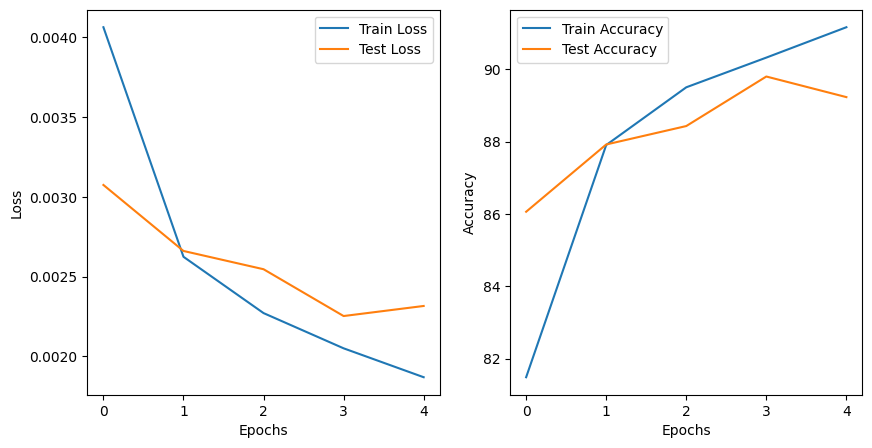

In [15]:
if hist is None:
    print("Training did not return any history.")  # hist가 None인 경우 학습 과정에 문제가 있었음을 출력
else:
    # 학습 결과를 시각화하는 함수 plot_results 정의
    def plot_results(history):
        # 그래프 크기 설정
        plt.figure(figsize=(10, 5))
        # 첫 번째 subplot: 손실 그래프
        plt.subplot(1, 2, 1)
        plt.plot(history['train_loss'], label='Train Loss')  # 학습 손실 그래프
        plt.plot(history['test_loss'], label='Test Loss')  # 테스트 손실 그래프
        plt.xlabel('Epochs')  # x축 레이블
        plt.ylabel('Loss')  # y축 레이블
        plt.legend()  # 범례 표시

        # 두 번째 subplot: 정확도 그래프
        plt.subplot(1, 2, 2)
        plt.plot(history['train_acc'], label='Train Accuracy')  # 학습 정확도 그래프
        plt.plot(history['test_acc'], label='Test Accuracy')  # 테스트 정확도 그래프
        plt.xlabel('Epochs')  # x축 레이블
        plt.ylabel('Accuracy')  # y축 레이블
        plt.legend()  # 범례 표시

        plt.show()  # 그래프 출력

    plot_results(hist)  # plot_results 함수를 호출하여 hist에 저장된 학습 결과를 시각화
